[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ContextLab/spam-classifier-llm-course/blob/main/Assignment2_SPAM_Classifier.ipynb)

# Assignment 2: Advanced SPAM Classifier with Multi-Method Comparison

**Course:** PSYC 51.17 - Models of Language and Communication  
**Deadline:** January 26, 2026 at 11:59 PM EST

---

## Overview

In this assignment, you will build a comprehensive spam classification system that implements multiple classification approaches, conducts rigorous comparative analysis, and performs extensive error analysis.

Please refer to the [full assignment instructions](https://contextlab.github.io/llm-course/assignments/assignment-2/) for detailed requirements and grading rubric.

---

## Table of Contents

1. [Setup and Data Loading](#setup)
2. [Part 1: Classifier Implementations](#part1)
3. [Part 2: Comprehensive Evaluation](#part2)
4. [Part 3: Error Analysis](#part3)
5. [Part 4: Adversarial Testing](#part4)
6. [Part 5: Real-World Considerations](#part5)
7. [Discussion and Reflection](#discussion)

<a id='setup'></a>
## 1. Setup and Data Loading

In [1]:
# Install required packages
!pip install -q transformers datasets scikit-learn pandas numpy matplotlib seaborn

In [2]:
import os
import zipfile
import urllib.request
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

Setup complete!


In [3]:
# Download the training dataset
dataset_url = 'https://raw.githubusercontent.com/ContextLab/spam-classifier-llm-course/main/training.zip'
dataset_path = 'training.zip'

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, dataset_path)
    print("Download complete.")
else:
    print("Dataset already exists.")

Download complete.


In [6]:
def load_dataset(zip_path):
    """
    Load emails from a zip archive containing spam/ and ham/ folders.

    Returns:
        emails: List of email texts
        labels: List of labels (1 for spam, 0 for ham)
    """
    # Extract if needed
    dataset_dir = Path(zip_path).with_suffix('')
    if not dataset_dir.exists():
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_dir)

    emails = []
    labels = []

    # Load spam
    spam_folder = dataset_dir / "training/spam"
    for file_path in spam_folder.iterdir():
        if file_path.is_file():
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                emails.append(f.read())
                labels.append(1)

    # Load ham
    ham_folder = dataset_dir / "training/ham"
    for file_path in ham_folder.iterdir():
        if file_path.is_file():
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                emails.append(f.read())
                labels.append(0)

    return emails, labels

emails, labels = load_dataset('training.zip')
print(f"Loaded {len(emails)} emails")
print(f"Spam: {sum(labels)}, Ham: {len(labels) - sum(labels)}")

Loaded 25287 emails
Spam: 12956, Ham: 12331


In [7]:
# TODO: Split data into train/validation/test sets
from sklearn.model_selection import train_test_split

# First split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    emails,
    labels,
    test_size=0.30,
    random_state=42,
    stratify=labels
)

# Second split: validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Dataset splits:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

print("\nClass distribution:")
print(f"Train spam: {sum(y_train)}, ham: {len(y_train) - sum(y_train)}")
print(f"Val spam: {sum(y_val)}, ham: {len(y_val) - sum(y_val)}")
print(f"Test spam: {sum(y_test)}, ham: {len(y_test) - sum(y_test)}")

Dataset splits:
Train: 17700
Validation: 3793
Test: 3794

Class distribution:
Train spam: 9069, ham: 8631
Val spam: 1943, ham: 1850
Test spam: 1944, ham: 1850


<a id='part1'></a>
## 2. Part 1: Multiple Classifier Implementations (40 points)

### 2.1 Traditional ML Baseline (15 points)

Implement **two** traditional ML classifiers with TF-IDF features.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# TODO: Implement TF-IDF vectorizer with appropriate parameters
# Document your feature engineering choices

vectorizer = TfidfVectorizer(
    lowercase=True,            # Normalize casing (e.g., "FREE" vs "free")
    stop_words='english',      # Remove common function words with low signal
    ngram_range=(1, 2),        # Unigrams + bigrams capture short spam phrases
    min_df=2,                  # Remove extremely rare tokens (noise)
    max_df=0.95,               # Remove near-constant terms
    sublinear_tf=True,         # Log-scaled term frequency (robust to long emails)
    norm='l2'                  # Required for linear SVM geometry
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shapes:")
print("Train:", X_train_tfidf.shape)
print("Val:", X_val_tfidf.shape)
print("Test:", X_test_tfidf.shape)

# TODO: Implement first traditional classifier
classifier1 = MultinomialNB(
    alpha=1.0   # Laplace smoothing for robustness to unseen tokens
)
classifier1.fit(X_train_tfidf, y_train)

# TODO: Implement second traditional classifier
classifier2 = SVC(
    kernel='linear',    # Linear kernel scales well for high-dimensional text
    C=1.0,              # Regularization strength
    probability=True,   # Enables ROC/AUC evaluation
    random_state=42
)

classifier2.fit(X_train_tfidf, y_train)

TF-IDF shapes:
Train: (17700, 362124)
Val: (3793, 362124)
Test: (3794, 362124)


SVC(kernel='linear', probability=True, random_state=42)

In [9]:
# -------------------------
# Traditional model predictions
# -------------------------
nb_preds = classifier1.predict(X_test_tfidf)
svm_preds = classifier2.predict(X_test_tfidf)


### 2.2 Neural/Transformer-Based Model (15 points)

Implement a transformer-based classifier (BERT, DistilBERT, etc.).

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# -------------------
# Check for GPU
# -------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------
# Load pre-trained model
# -------------------------

model_name = "distilbert-base-uncased"  # fast, strong baseline
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2).to(device)

# -------------------------
# Prepare Hugging Face datasets
# -------------------------

train_dataset = Dataset.from_dict({"text": X_train,"label": y_train})
val_dataset = Dataset.from_dict({"text": X_val,"label": y_val})
test_dataset = Dataset.from_dict({"text": X_test,"label": y_test})

# -------------------------
# Tokenization
# -------------------------

def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set PyTorch format
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/17700 [00:00<?, ? examples/s]

Map:   0%|          | 0/3793 [00:00<?, ? examples/s]

Map:   0%|          | 0/3794 [00:00<?, ? examples/s]

In [13]:
# -------------------------
# Metrics
# -------------------------

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc,"precision": precision,"recall": recall,"f1": f1}

# -------------------------
# Training configuration
# -------------------------

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"
)
# -------------------------
# Trainer
# -------------------------

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# -------------------------
# Fine-tune the model
# -------------------------

trainer.train()

/tmp/ipython-input-293140599.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.037200,0.023782,0.994991,0.993333,0.996912,0.995119
2,0.006600,0.033302,0.994200,0.997411,0.991251,0.994321
3,0.000100,0.028521,0.995782,0.996394,0.995368,0.995881


TrainOutput(global_step=3321, training_loss=0.030013927231734582, metrics={'train_runtime': 1258.6392, 'train_samples_per_second': 42.188, 'train_steps_per_second': 2.639, 'total_flos': 3517009434316800.0, 'train_loss': 0.030013927231734582, 'epoch': 3.0})

In [17]:
# -------------------------
# Traditional model probabilities
# -------------------------

# Multinomial Naive Bayes probabilities
nb_probs = classifier1.predict_proba(X_test_tfidf)[:, 1]

# Linear SVM probabilities
svm_probs = classifier2.predict_proba(X_test_tfidf)[:, 1]

In [14]:
# -------------------------
# Transformer probabilities
# -------------------------

predictions = trainer.predict(test_dataset)
bert_logits = predictions.predictions
bert_probs = torch.softmax(torch.tensor(bert_logits), dim=1)[:, 1].numpy()

In [15]:
# -------------------------
# Transformer predictions
# -------------------------
bert_preds = np.argmax(bert_logits, axis=1)

### 2.3 Ensemble Method (10 points)

Create an ensemble that combines your best models.

In [18]:
# TODO: Implement ensemble method (voting, stacking, or boosting)
# Document your ensemble strategy

# -------------------------
# Soft voting ensemble
# -------------------------

ensemble_probs = (nb_probs + svm_probs + bert_probs) / 3
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

<a id='part2'></a>
## 3. Part 2: Comprehensive Evaluation (25 points)

In [19]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_and_collect(
    name,
    y_true,
    y_pred,
    y_prob=None,
    plot_cm=True,
    verbose=True
):
    """
    Evaluate a classifier, optionally plot confusion matrix,
    print reports, and return metrics as a dict.
    """

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_prob) if y_prob is not None else None
    }

    if verbose:
        print("\n" + "=" * 50)
        print(f"{name} Evaluation")
        print("=" * 50)

        for k, v in metrics.items():
            if k != "Model" and v is not None:
                print(f"{k}: {v:.4f}")

        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=["Ham", "Spam"]))

    if plot_cm:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Ham", "Spam"],
            yticklabels=["Ham", "Spam"]
        )
        plt.title(f"{name} - Confusion Matrix")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()

    return metrics



Naive Bayes (TF-IDF) Evaluation
Accuracy: 0.9879
Precision: 0.9867
Recall: 0.9897
F1: 0.9882
AUC: 0.9989

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99      1850
        Spam       0.99      0.99      0.99      1944

    accuracy                           0.99      3794
   macro avg       0.99      0.99      0.99      3794
weighted avg       0.99      0.99      0.99      3794



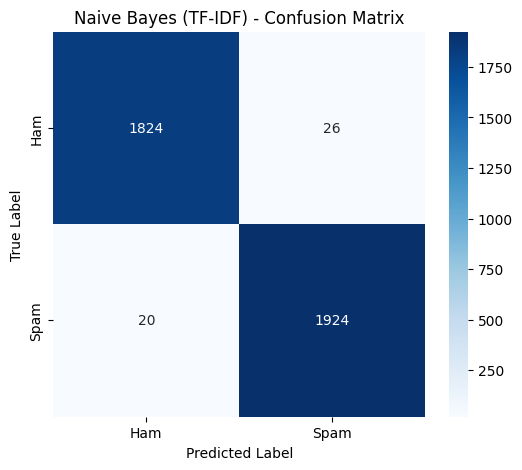


Linear SVM (TF-IDF) Evaluation
Accuracy: 0.9905
Precision: 0.9862
Recall: 0.9954
F1: 0.9908
AUC: 0.9991

Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      0.99      0.99      1850
        Spam       0.99      1.00      0.99      1944

    accuracy                           0.99      3794
   macro avg       0.99      0.99      0.99      3794
weighted avg       0.99      0.99      0.99      3794



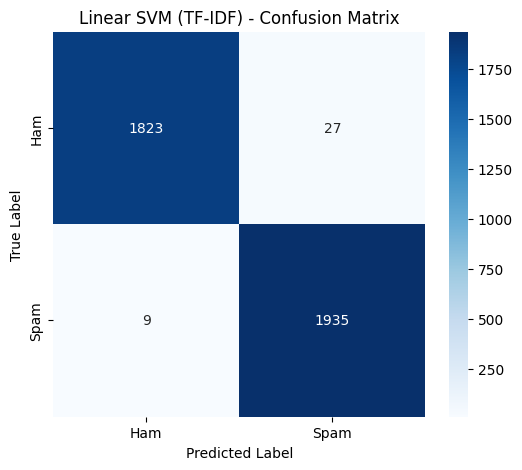


DistilBERT Evaluation
Accuracy: 0.9921
Precision: 0.9979
Recall: 0.9866
F1: 0.9922
AUC: 0.9998

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99      1850
        Spam       1.00      0.99      0.99      1944

    accuracy                           0.99      3794
   macro avg       0.99      0.99      0.99      3794
weighted avg       0.99      0.99      0.99      3794



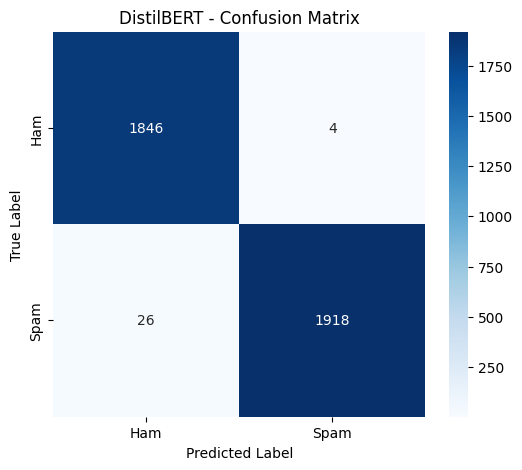


Ensemble (Soft Voting) Evaluation
Accuracy: 0.9950
Precision: 0.9944
Recall: 0.9959
F1: 0.9951
AUC: 0.9997

Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      0.99      0.99      1850
        Spam       0.99      1.00      1.00      1944

    accuracy                           0.99      3794
   macro avg       1.00      0.99      0.99      3794
weighted avg       0.99      0.99      0.99      3794



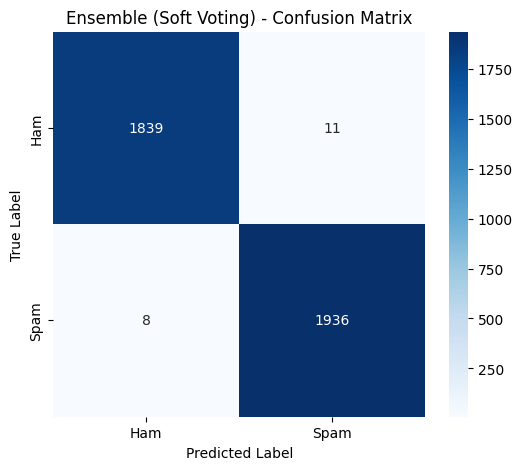

,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Naive Bayes (TF-IDF),0.9879,0.9867,0.9897,0.9882,0.9989
Linear SVM (TF-IDF),0.9905,0.9862,0.9954,0.9908,0.9991
DistilBERT,0.9921,0.9979,0.9866,0.9922,0.9998
Ensemble (Soft Voting),0.9950,0.9944,0.9959,0.9951,0.9997


In [20]:
results = []

results.append(
    evaluate_and_collect(
        "Naive Bayes (TF-IDF)",
        y_test,
        nb_preds,
        nb_probs
    )
)

results.append(
    evaluate_and_collect(
        "Linear SVM (TF-IDF)",
        y_test,
        svm_preds,
        svm_probs
    )
)

results.append(
    evaluate_and_collect(
        "DistilBERT",
        y_test,
        bert_preds,
        bert_probs
    )
)

results.append(
    evaluate_and_collect(
        "Ensemble (Soft Voting)",
        y_test,
        ensemble_preds,
        ensemble_probs
    )
)

results_df = pd.DataFrame(results).set_index("Model")
display(results_df.round(4))


In [21]:
# TODO: Measure computational efficiency
# Training time, inference time, model size, throughput
import time

def time_training(model, X, y):
    start = time.time()
    model.fit(X, y)
    return time.time() - start

nb_train_time = time_training(
    MultinomialNB(alpha=1.0), X_train_tfidf, y_train
)

svm_train_time = time_training(
    SVC(kernel="linear", C=1.0), X_train_tfidf, y_train
)

In [22]:
bert_train_time = trainer.state.log_history[-1]["train_runtime"]

In [23]:
from sklearn.model_selection import cross_val_score

def time_inference(model, X):
    start = time.time()
    model.predict(X)
    return time.time() - start

nb_infer_time = time_inference(classifier1, X_test_tfidf)
svm_infer_time = time_inference(classifier2, X_test_tfidf)

start = time.time()
trainer.predict(test_dataset)
bert_infer_time = time.time() - start

In [24]:
import sys

model_sizes = {
    "Naive Bayes": sys.getsizeof(classifier1),
    "Linear SVM": sys.getsizeof(classifier2),
    "DistilBERT": sum(p.numel() for p in model.parameters()) * 4 / (1024**2)  # MB
}

model_sizes

{'Naive Bayes': 48, 'Linear SVM': 48, 'DistilBERT': 255.41309356689453}

In [25]:
efficiency_df = pd.DataFrame({
    "Training Time (s)": [nb_train_time, svm_train_time, bert_train_time],
    "Inference Time (s)": [nb_infer_time, svm_infer_time, bert_infer_time],
    "Model Size": ["Small", "Medium", f"{model_sizes['DistilBERT']:.1f} MB"]
}, index=["Naive Bayes", "Linear SVM", "DistilBERT"])

display(efficiency_df)

,Training Time (s),Inference Time (s),Model Size
Naive Bayes,0.044048,0.011014,Small
Linear SVM,211.174636,15.704975,Medium
DistilBERT,1258.639200,29.632801,255.4 MB


In [ ]:
# TODO: Cross-validation with statistical significance testing
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

nb_pipeline = Pipeline([
    ("tfidf", vectorizer),
    ("nb", MultinomialNB(alpha=1.0))
])

svm_pipeline = Pipeline([
    ("tfidf", vectorizer),
    ("svm", SVC(kernel="linear", C=1.0))
])

nb_f1 = cross_val_score(nb_pipeline, emails, labels, cv=5, scoring="f1")
svm_f1 = cross_val_score(svm_pipeline, emails, labels, cv=5, scoring="f1")

In [ ]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(nb_f1, svm_f1)

print(f"Paired t-test (NB vs SVM)")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value:     {p_value:.4e}")

<a id='part3'></a>
## 4. Part 3: Error Analysis (20 points)

In [ ]:
# TODO: Identify and analyze at least 20 misclassified emails
# - 10 false positives (ham classified as spam)
# - 10 false negatives (spam classified as ham)

# Categorize errors and analyze patterns

In [ ]:
# TODO: Feature importance analysis
# What words/patterns are most predictive?

<a id='part4'></a>
## 5. Part 4: Adversarial Testing (10 points)

In [ ]:
# TODO: Create at least 5 adversarial emails
# Test on all classifiers and analyze which are most robust

adversarial_emails = [
    # Example: spam trying to evade detection
    """Fr33 V1agra! Click here for amazing deals!

    The weather today is quite nice. I hope you are doing well.
    Best regards from a legitimate sender.""",

    # Add more adversarial examples
]

In [ ]:
# TODO: Test robustness against perturbations
# - Typos and misspellings
# - Case variations
# - Synonym replacement

<a id='part5'></a>
## 6. Part 5: Real-World Considerations (5 points)

### Class Imbalance Discussion

(How did you handle class imbalance? What happens if spam/ham ratio changes in production?)

### Deployment Scenarios

Which model would you choose for:
- **Mobile email app** (fast inference, small size):
- **Email server** (high throughput):
- **Maximum accuracy** (no constraints):

(Justify with evidence from your experiments)

<a id='discussion'></a>
## 7. Discussion and Reflection

### Key Findings

(What did you learn about spam classification? Which approach worked best and why?)

### Limitations

(What are the limitations of your approach? What would you improve with more time?)

### Reflection

(What was challenging? What surprised you about the results?)

---

## Submission Checklist

- [ ] At least 3 classifiers implemented (2 traditional + 1 neural + ensemble)
- [ ] All metrics computed and comparison table created
- [ ] Cross-validation with statistical testing
- [ ] At least 20 error cases analyzed
- [ ] At least 5 adversarial examples created and tested
- [ ] Deployment recommendations with justification
- [ ] Discussion and reflection complete
- [ ] Notebook runs without errors

**To submit:** Commit and push this notebook to your GitHub repository before the deadline.